# Preparation

In [20]:
import requests  # send request
from bs4 import BeautifulSoup  # parse web pages
import pandas as pd  # csv
from time import sleep  # wait
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import Row
# from pyspark.sql.types import StringType, StructType, StructField
from pyspark.sql.types import *
# import pyspark.sql.functions as F
from pyspark.sql.functions import *

from tqdm import tqdm
import re
import os


# Q2

## Q2_1

In [21]:
# url = "https://paulgraham.com/articles.html"
# page = requests.get(url)
# soup = BeautifulSoup(page.text, 'html.parser')
# article_list = soup.find("tr", valign="top").findAll("td")[2].findAll("table")[1].findAll("a")
# suburl = "https://paulgraham.com/"

In [22]:
# # remove all files in a directory
# import shutil  
# shutil.rmtree('data/paul_articles') 
# os.mkdir('data/paul_articles')  

In each paragraph, texts are seperated into different lines in unknown situations. In this case, I first convert the soup object into a string, replace `'\n'` into `""` and split the string by `<br/><br/>`, which is a kind of paragraph seperator in html. Now each sentence has been grouped into their own paragraph. However, there are also some annoying html tags in the text. I use regular expression to remove them.

In [23]:
# for i in tqdm(article_list):
#     try:
#         href = i['href']
#         if "http" in href:
#             article_page = requests.get(href)
#             split_text = re.split('\n{2,}', article_page.text)
#             text = ("\n").join([i.replace("\n", " ").strip("-").strip() for i in split_text if i != ""]).strip("\n")
#         else:
#             article_page = requests.get(f"{suburl}{href}")
#             article_soup = BeautifulSoup(article_page.text, 'html.parser')
#             article_text = article_soup.find("font", face = "verdana")
#             para_list = str(article_text).replace("\n", " ").split("<br/><br/>")
#             text = ("\n").join([re.sub('<.*?>', '', i).strip() for i in para_list if i != ""]).strip("\n")
            
#         txt_file = i.text.replace("/", "or").replace("?", "").replace(",","").replace(":", "")
        
#         with open(f"data/paul_articles/{txt_file}.txt", "w") as f:
#             f.write(text)
#     except Exception as e:
#         print(f"Error with {i.text}: {e}")
#         continue

In [24]:
# import os
# print(len(article_list))
# print(len(os.listdir("data/paul_articles")))

## Q2_2

In [25]:
# spark.conf.set("spark.driver.memory", "4g")
# spark.conf.set("spark.executor.memory", "4g")

spark = SparkSession.builder.config('spark.ui.port', 64050).config("spark.executor.memory", "16g").config("spark.driver.memory", "16g").appName("proj1_q2").getOrCreate()
text_rdd = spark.sparkContext.textFile("data/paul_articles/*.txt")

24/04/14 09:10:39 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [26]:
text_rdd.take(3)

['March 2006, rev August 2009',
 "A couple days ago I found to my surprise that I'd been granted a patent. It issued in 2003, but no one told me.  I wouldn't know about it now except that a few months ago, while visiting Yahoo, I happened to run into a Big Cheese I knew from working there in the late nineties.  He brought up something called Revenue Loop, which Viaweb had been working on when they bought us.",
 'The idea is basically that you sort search results not in order of textual "relevance" (as search engines did then) nor in order of how much advertisers bid (as Overture did) but in order of the bid times the number of transactions.  Ordinarily you\'d do this for shopping searches, though in fact one of the features of our scheme is that it automatically detects which searches are shopping searches.']

In [27]:
text_rdd.filter(lambda x: "suggestion" in x).take(3)

["In practice I doubt any government would have the balls to try this, or the brains to do it right.  I didn't mean it as a practical suggestion, but more as an exploration of the lower bound of what it would take to create a startup hub deliberately.",
 "I have no illusions about how eagerly this suggestion will   be adopted.  Public schools probably couldn't stop teaching English even if they wanted to; they're probably required to by law.  But here's a related suggestion that goes with the grain instead of against it: that universities establish a writing major.  Many of the students who now major in English would major in writing if they could, and most would be better off.",
 'Distractions are the thing you can least afford in a startup.  And conversations with corp dev are the worst sort of distraction, because as well as consuming your attention they undermine your morale.  One of the tricks to surviving a grueling process is not to stop and think how tired you are.  Instead you

In my Pyspark task, I have a rdd that contains texts (each element is a paragraph) written by a author. Now I want to find paragraphs talking about 'career planning', could you help me find some key phrases from raw contents which I will give you to help me filter elemetns in rdd? If Ok I will give you the raw contents. And you will give me the key phrases.

The raw pages I give the gpt are:
-   Ideas for Startups

There are many phrases that can be used to describe career planning, and there are ways I think can be used:
- For each phrase in the phrases_list, I will tokenize it to a small phrase_tuple. If one paragraph contains all words of any phrase_tuple (even in disorder or in different morphologys), I will consider it as a paragraph talking about career planning, which will be kept in the final result.
- Let all tokens in the paragraph be the nodes of a graph, and the edges are the co-occurrence of two words in the same paragraph. Then I will use a graph algorithm to find the subgraph that contains all nodes in the phrase. If the subgraph is connected, I will consider it as a paragraph talking about career planning.

> Word tenses and case should be ignored because authors may use different tenses and case to convey the same meaning. So I will normalize the words. What I used to normalize words is deleting letters. If `coming` is converted to `come`, then `coming ` may not be pointed out, so I use `com` to represent `coming`. But this may relate to some unwanted words like `common`. In my opinion, more is better then less. 

In [28]:
phrases_list = [
   "Career plan",
   "suggestion for",
   "suggestion of",
   "suggestion about",
   "Career development",
    "Skill development",
    "Career goal",
    "Job market",
    "Career mentor",
    "Career counsel",
    "Career transition",
    "Self-assessment",
    "Career prospect",
    "Industry research",
    "Resume and cover letter",
    "Interview preparation",
    "Professional networking",
    "Continuing education",
    "Job satisfaction",
    "Work life balance",
    "Career success",
    "Professional ethic",
    "Career growth"
    "Find startup",
    "Generat startup",
    "Com up zip_with",
    "Value of initial",
    "Start point",
    "Partial solution",
    "Max future option",
    "Work on new technolog",
    "Conversation with friend",
    "University research startup",
    "Importance of collaboration and friendship",
   "Mind wander and idea generation",
    "Mak thing eas to use",
   "Mak something people want",
    "Redefin problem",
    "Mak thing cheaper and commoditiz",
   "Mak thing easier",
   "Design for exit strateg",
   "Product development on spec",
   "Counteract monopol",
   "Accident startup",
   "Do what hacker enjoy"
]
phrases_tuple_list = [tuple(x.lower().split(" ")) for x in phrases_list]
phrases_tuple_list[-5:]

[('design', 'for', 'exit', 'strateg'),
 ('product', 'development', 'on', 'spec'),
 ('counteract', 'monopol'),
 ('accident', 'startup'),
 ('do', 'what', 'hacker', 'enjoy')]

In [29]:
career_suggestion = text_rdd.filter(lambda x: any([all([word in x.lower() for word in phrase]) for phrase in phrases_tuple_list]))
print(career_suggestion.count())
print(text_rdd.count())
career_suggestion.take(4)

452
10136


["If you just order the results in order of bids, you can make the search results useless, because the first results could be dominated by lame sites that had bid the most.  But if you order results by bid multiplied by transactions, far from selling out, you're getting a better measure of relevance.  What could be a better sign that someone was satisfied with a search result than going to the site and buying something?",
 "Want to start a startup?  Get funded by Y Combinator.     August 2008Raising money is the second hardest part of starting a startup. The hardest part is making something people want: most startups that die, die because they didn't do that.  But the second biggest cause of death is probably the difficulty of raising money. Fundraising is brutal.",
 "One answer to that is obvious: because you need money to live on. It's a fine idea in principle to finance your startup with its own revenues, but you can't create instant customers.  Whatever you make, you have to sell a

In [30]:
spark.createDataFrame(career_suggestion.map(lambda x: Row(text=x))).write.format("parquet").mode("overwrite").save("output/career_suggestion.parquet")

## Q2_3

In [31]:
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_noun_phrases(text):
    doc = nlp(text)
    noun_phrases = [chunk.text for chunk in doc.noun_chunks]
    return noun_phrases

spark.udf.register("extract_noun_phrases", extract_noun_phrases, ArrayType(StringType()))   # 第三个参数指定返回类型

24/04/14 09:10:43 WARN SimpleFunctionRegistry: The function extract_noun_phrases replaced a previously registered function.


<function __main__.extract_noun_phrases(text)>

In [32]:
noun_rdd = text_rdd.flatMap(extract_noun_phrases)
noun_rdd.take(5)

['I', 'my surprise', 'I', 'a patent', 'It']

In [33]:
noun_count = noun_rdd.countByValue()
noun_count_list = sorted(noun_count.items(), key=lambda x: x[1], reverse=True)
noun_freq = {i[0]:i[1] for i in noun_count_list[39:50]}
noun_freq

{'the company': 276,
 'Lisp': 266,
 'everyone': 264,
 'software': 256,
 'the way': 256,
 'themselves': 253,
 'him': 250,
 'a company': 240,
 'those': 236,
 'Google': 232,
 'anyone': 217}

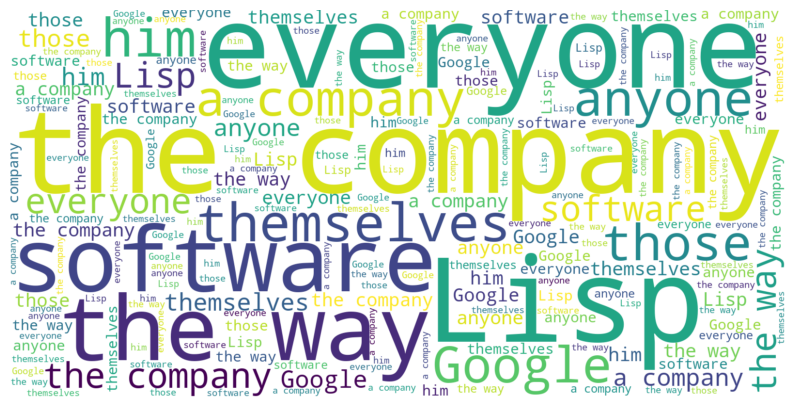

In [34]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, background_color="white",repeat = True).generate_from_frequencies(noun_freq).to_file("output/proj1_q2_noun_wordcloud.png")

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [38]:
from stylecloud import gen_stylecloud

# 将字典转换为包含文本内容的列表
text_list = [(i[0],i[1]) for i in noun_count_list[39:50]]

gen_stylecloud(
    text = noun_freq,
    # file_path='yourtable.csv',   # 必要参数，语料的路径，如果语料是列表格式，则改用 text 参数
    size=(1500,1500),         # 词云图的长宽，设置更大的数字可以增加成图的分辨率，但代码运行时间会随之增加
    max_words=400,          # 词云图中的最大词语数量
    max_font_size=500,      # 词云图中字号的最大值
    # font_path=r'C:\Windows\Fonts\SimHei.ttf', # 字体是必要的参数，否则中文会显示异常
    output_name='output/proj1_q2_noun_stylecloud.png',       # 必要参数，保存词云图的路径
    # colors=['#ecf0f1', '#3498db', '#e74c3c'],
    palette='colorbrewer.diverging.Spectral_11',
    background_color='white',
    icon_name= "fas fa-comment-alt",
    collocations = False,
    invert_mask=False,
    random_state = 59
)